In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import xml.etree.ElementTree as ET
import os
from glob import glob
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


In [4]:
device = 'cuda'

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir: str, image_size: int = 227, transform: T.Compose = T.Compose([])):
        self.image_size = image_size
        self.root_dir = root_dir
        self.transform = transform
        self.img_paths = sorted(glob(f'{self.root_dir}/*.jpg'))
        self.xml_paths = sorted(glob(f'{self.root_dir}/*.xml'))
        self.cls2ix = {'cucumber': 0, 'eggplant': 1, 'mushroom': 2}
        self.ix2cls = {v: k for k, v in self.cls2ix.items()}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        annotation = ET.parse(self.xml_paths[idx])
        filename = annotation.find('filename').text
        image = Image.open(os.path.join(self.root_dir, filename)).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        label = annotation.find('object').find('name').text
        label = self.cls2ix[label]
        
        xmin = int(annotation.find('object').find('bndbox').find('xmin').text)
        ymin = int(annotation.find('object').find('bndbox').find('ymin').text)
        xmax = int(annotation.find('object').find('bndbox').find('xmax').text)
        ymax = int(annotation.find('object').find('bndbox').find('ymax').text)
        
        bbox = torch.tensor([xmin, ymin, xmax, ymax], dtype=torch.float32) / self.image_size
        
        return image, bbox, torch.tensor(label, dtype=torch.long)


In [6]:
train_aug = T.Compose([
    T.Resize((227, 227)),
    T.ToTensor(),
    T.ColorJitter(
        brightness=0.2,  
        contrast=0.2,    
        saturation=0.2, 
        hue=0.1         
    ),
    T.RandomRotation(degrees=15),  
    T.RandomHorizontalFlip(p=0.3),
])

valid_aug = T.Compose([
    T.Resize((227, 227)),
    T.ToTensor()
])

train_dataset = CustomDataset(root_dir='/home/polyakovk/ds_bootcamp_linux/proj1/Veg/loc_train', image_size=227, transform=train_aug)
valid_dataset = CustomDataset(root_dir='/home/polyakovk/ds_bootcamp_linux/proj1/Veg/loc_valid', image_size=227, transform=valid_aug)


In [15]:
train_dataset.cls2ix
ind2class = {j:i for i,j in train_dataset.cls2ix.items()}
ind2class

{0: 'cucumber', 1: 'eggplant', 2: 'mushroom'}

In [8]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [10]:
class ResNet18ForLocalization(nn.Module):
    def __init__(self):
        super(ResNet18ForLocalization, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
       
        self.fc1 = nn.Linear(1000, 1024)
        self.fc2 = nn.Linear(1024, 4)  
        self.fc3 = nn.Linear(1024, 3)
        self.dropout = nn.Dropout() 
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        for param in self.fc1.parameters():
            param.requires_grad = True
        for param in self.fc2.parameters():
            param.requires_grad = True
        for param in self.fc3.parameters():
            param.requires_grad = True

    def forward(self, x):
        features = self.model(x)
        x = self.fc1(features)
        x = torch.relu(x)
        bbox_outputs = self.fc2(x)
        class_outputs = self.fc3(x)
        return bbox_outputs, class_outputs

In [11]:
device = 'cuda'
model = ResNet18ForLocalization().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()


In [12]:
def fit(model: nn.Module, n_epochs: int, optimizer: torch.optim.Optimizer, train_loader: DataLoader, valid_loader: DataLoader, history=None) -> dict:
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'train_losses_bbox': [],
        'valid_accs': [],
        'valid_losses': [],
        'valid_losses_bbox': [],
        'train_f1s': [],
        'valid_f1s': [],
    }
    
    model.to(device)
    
    for epoch in range(n_epochs):
        print(f'{epoch} эпоха обучения')
        model.train()
        batch_accs = []
        batch_losses_class = []
        batch_losses_bbox = []
        batch_f1s = []
        
        for images, bboxes, labels in train_loader:
            images = images.to(device)
            bboxes = bboxes.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            bbox_pred, class_pred = model(images)
            
            loss_class = criterion_class(class_pred, labels)
            loss_bbox = criterion_bbox(bbox_pred, bboxes)
            loss = loss_class + loss_bbox
            loss.backward()
            optimizer.step()

            batch_losses_class.append(loss_class.item())
            batch_losses_bbox.append(loss_bbox.item())
            batch_accs.append((class_pred.argmax(dim=1) == labels).cpu().numpy().mean())

            y_true = labels.cpu().numpy()
            y_pred_labels = class_pred.argmax(dim=1).cpu().numpy()
            batch_f1s.append(f1_score(y_true, y_pred_labels, average='weighted'))

        history['train_losses'].append(np.mean(batch_losses_class))
        history['train_losses_bbox'].append(np.mean(batch_losses_bbox))
        history['train_accs'].append(np.mean(batch_accs))
        history['train_f1s'].append(np.mean(batch_f1s))

        model.eval()
        batch_accs = []
        batch_losses_class = []
        batch_losses_bbox = []
        batch_f1s = []

        with torch.no_grad():
            for images, bboxes, labels in valid_loader:
                images = images.to(device)
                bboxes = bboxes.to(device)
                labels = labels.to(device)
                
                bbox_pred, class_pred = model(images)
                loss_class = criterion_class(class_pred, labels)
                loss_bbox = criterion_bbox(bbox_pred, bboxes)
                loss = loss_class + loss_bbox

                batch_losses_class.append(loss_class.item())
                batch_losses_bbox.append(loss_bbox.item())
                batch_accs.append((class_pred.argmax(dim=1) == labels).cpu().numpy().mean())

                y_true = labels.cpu().numpy()
                y_pred_labels = class_pred.argmax(dim=1).cpu().numpy()
                batch_f1s.append(f1_score(y_true, y_pred_labels, average='weighted'))

        history['valid_losses'].append(np.mean(batch_losses_class))
        history['valid_losses_bbox'].append(np.mean(batch_losses_bbox))
        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_f1s'].append(np.mean(batch_f1s))
        
        print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, '
            f'loss {history["train_losses"][-1]:.4f} (class) + {history["train_losses_bbox"][-1]:.4f} (bbox), '
            f'f1 {history["train_f1s"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, '
            f'loss {history["valid_losses"][-1]:.4f} (class) + {history["valid_losses_bbox"][-1]:.4f} (bbox), '
            f'f1 {history["valid_f1s"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()

    return history


In [13]:
logs = fit(model, 40, optimizer, train_loader, valid_loader)

0 эпоха обучения
train: accuracy 0.5521, loss 0.8882 (class) + 0.3984 (bbox), f1 0.5222
valid: accuracy 0.7368, loss 0.5783 (class) + 0.0817 (bbox), f1 0.6856
-----------------------------------

1 эпоха обучения
train: accuracy 0.8250, loss 0.4512 (class) + 0.1946 (bbox), f1 0.8161
valid: accuracy 0.9737, loss 0.1672 (class) + 0.1920 (bbox), f1 0.9736
-----------------------------------

2 эпоха обучения
train: accuracy 0.9302, loss 0.1583 (class) + 0.1272 (bbox), f1 0.9313
valid: accuracy 0.9474, loss 0.1748 (class) + 0.0954 (bbox), f1 0.9481
-----------------------------------

3 эпоха обучения
train: accuracy 0.9313, loss 0.1419 (class) + 0.1069 (bbox), f1 0.9316
valid: accuracy 0.9211, loss 0.1658 (class) + 0.0567 (bbox), f1 0.9224
-----------------------------------

4 эпоха обучения
train: accuracy 0.9250, loss 0.1705 (class) + 0.0795 (bbox), f1 0.9284
valid: accuracy 0.9737, loss 0.0860 (class) + 0.0964 (bbox), f1 0.9736
-----------------------------------

5 эпоха обучения
tra

In [21]:
import json

def save_history(history, file_path):
    with open(file_path, 'w') as f:
        json.dump(history, f)
        
save_history(logs, 'training_history.json')

In [28]:
import json

with open('/home/polyakovk/ds_bootcamp_linux/proj1/training_history.json', 'r') as f:
    history = json.load(f)

print(history.keys())  

dict_keys(['train_accs', 'train_losses', 'train_losses_bbox', 'valid_accs', 'valid_losses', 'valid_losses_bbox', 'train_f1s', 'valid_f1s'])


In [27]:
!pwd

/home/polyakovk/ds_bootcamp_linux/proj1


In [16]:
torch.save(model.state_dict(), 'resnet_weight.pt')
torch.save(model, 'resnet18.py')


In [431]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    
    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].legend()
    
    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].legend()
    
    plt.show()

In [19]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(2, 2, figsize=(18, 10))
    
    # Losses
    ax[0, 0].plot(history['train_losses'], label='train loss')
    ax[0, 0].plot(history['valid_losses'], label='valid loss')
    ax[0, 0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0, 0].grid(grid)
    ax[0, 0].legend()
    
    ax[0, 1].plot(history['train_losses_bbox'], label='train bbox loss')
    ax[0, 1].plot(history['valid_losses_bbox'], label='valid bbox loss')
    ax[0, 1].set_title(f'Bounding Box Loss on epoch {len(history["train_losses"])}')
    ax[0, 1].grid(grid)
    ax[0, 1].legend()
    
    # Accuracy
    ax[1, 0].plot(history['train_accs'], label='train acc')
    ax[1, 0].plot(history['valid_accs'], label='valid acc')
    ax[1, 0].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1, 0].grid(grid)
    ax[1, 0].legend()
    
    # F1 Scores
    ax[1, 1].plot(history['train_f1s'], label='train F1-score')
    ax[1, 1].plot(history['valid_f1s'], label='valid F1-score')
    ax[1, 1].set_title(f'F1 Score on epoch {len(history["train_losses"])}')
    ax[1, 1].grid(grid)
    ax[1, 1].legend()
    
    # Customizing subplot appearance
    for a in ax.flat:
        a.set_xlabel('Epoch')
        a.set_ylabel('Value')

    plt.tight_layout()
    plt.show()

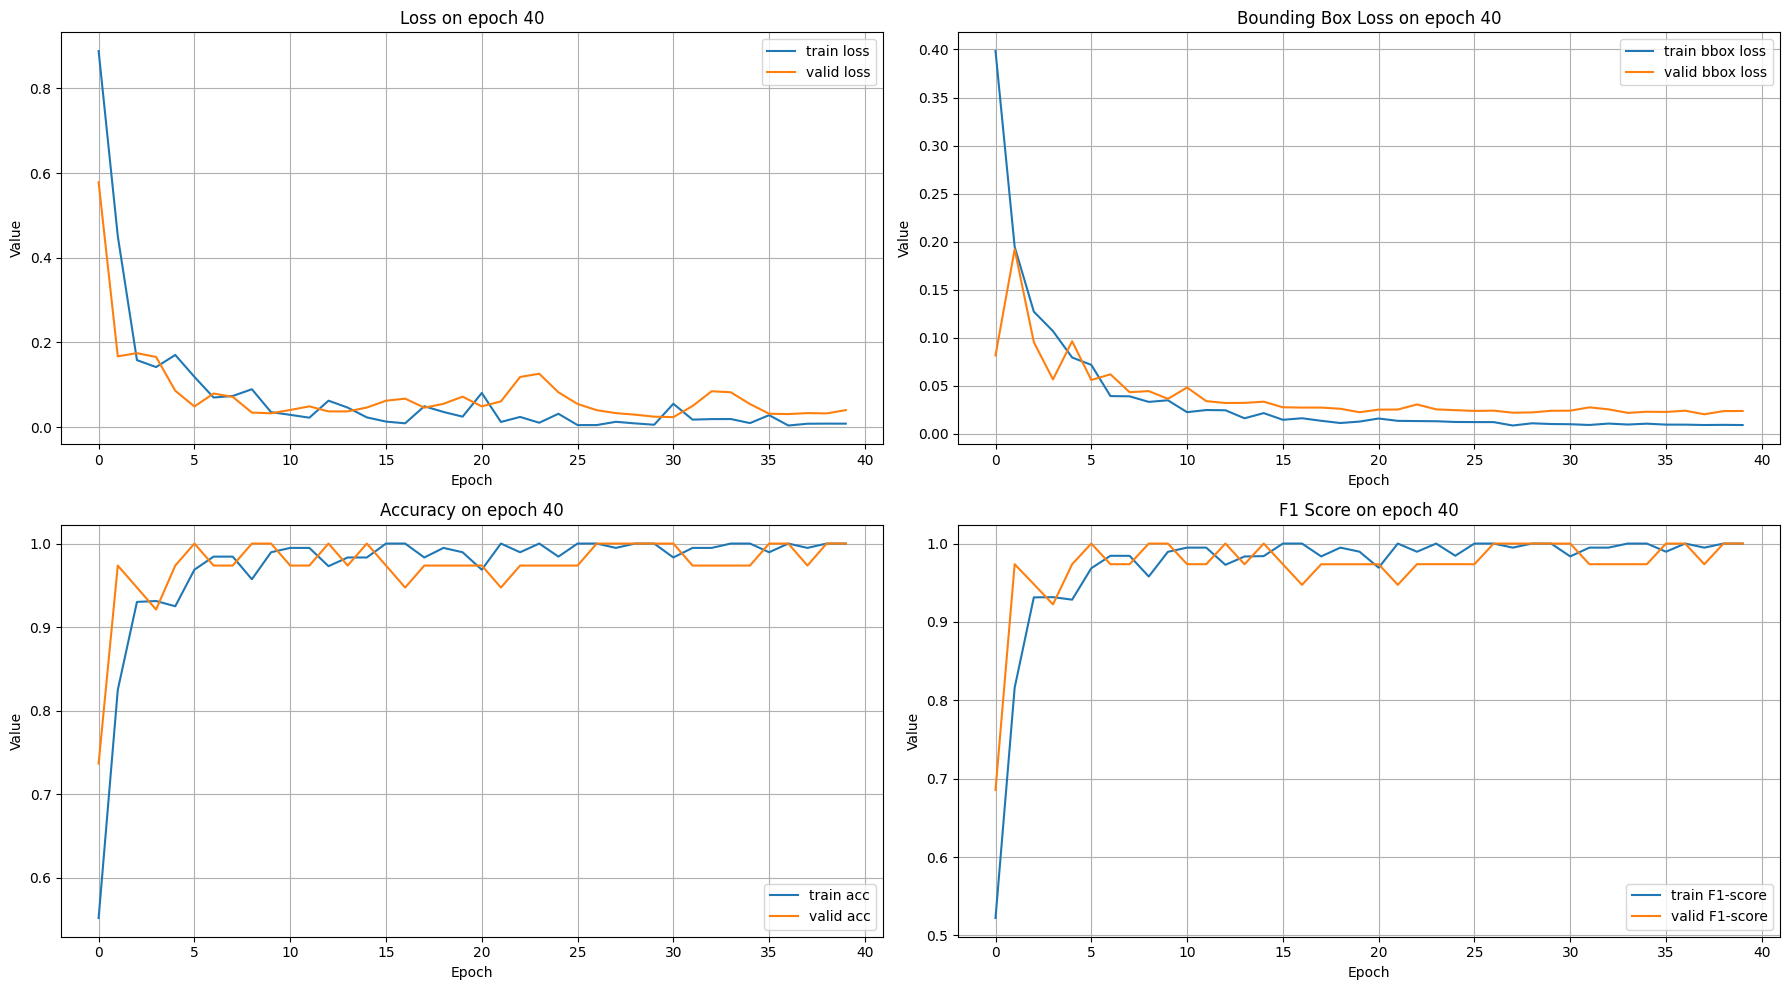

In [20]:
plot_history(logs)

(227, 227)


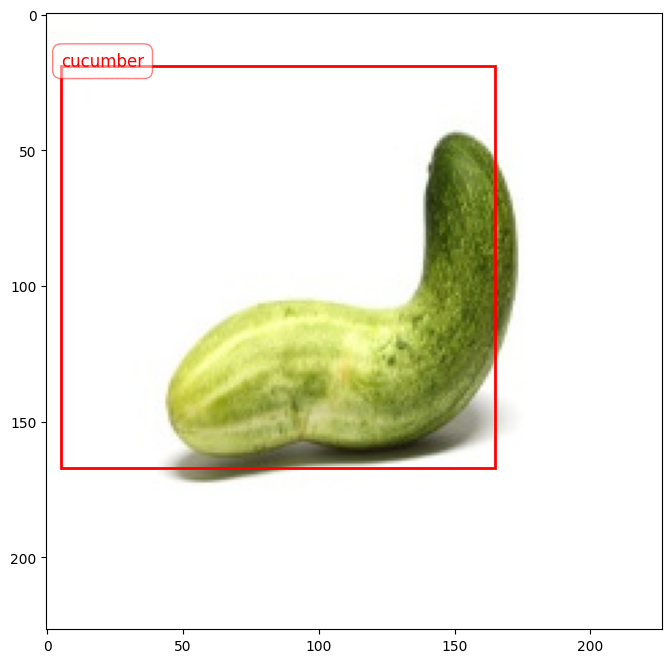

: 

In [473]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as T
import torch

def show_random_prediction(model, valid_dataset, device):
    # Выберите случайный индекс
    idx = random.randint(0, len(valid_dataset) - 1)
    
    # Получите путь к изображению и загрузите его
    img_path = valid_dataset.img_paths[idx]
    image = Image.open(img_path).convert("RGB")
    
    # Примените те же преобразования, что использовались для валидации
    transform = valid_dataset.transform
    image_tensor = transform(image).unsqueeze(0).to(device)  # Добавьте размерность batch

    # Пропустите изображение через модель
    model.eval()
    with torch.no_grad():
        bbox_pred, class_pred = model(image_tensor)
    
    # Получите предсказанные классы и bounding boxes
    bbox_pred = bbox_pred.cpu().numpy().flatten()
    class_pred = class_pred.cpu().numpy().flatten()
    
    # Преобразуйте bounding box в оригинальные координаты
    xmin, ymin, xmax, ymax = bbox_pred
    width, height = image.size
    print(image.size)
    xmin = int(xmin * width)
    ymin = int(ymin * height)
    xmax = int(xmax * width)
    ymax = int(ymax * height)

    # Найдите индекс класса с максимым значением
    class_index = class_pred.argmax()
    class_label = valid_dataset.ix2cls[class_index]

    # Отобразите изображение и предсказания
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Нарисуйте bounding box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    # Добавьте текст с классом
    plt.text(xmin, ymin, class_label, color='red', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='red', boxstyle='round,pad=0.5'))
    
    plt.show()

# Использование функции
show_random_prediction(model, valid_dataset, device)


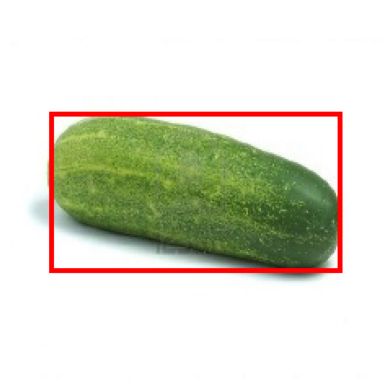

In [396]:
import os
import random
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def draw_bbox_on_image(image_path, bbox):
    """Наложить рамку на изображение и сохранить результат."""
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # Рисуем рамку (bbox)
    draw.rectangle(bbox, outline="red", width=3)
    
    # Печатаем изображение с помощью matplotlib
    plt.imshow(image)
    plt.axis('off')  # Отключаем оси
    plt.show()

def parse_xml_for_bbox(xml_path):
    """Извлечь координаты рамки из XML-файла."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Предполагается, что в XML есть элемент <object> и в нем <bndbox>
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        return (xmin, ymin, xmax, ymax)
    
    return None

def random_image_with_bbox(train_folder):
    """Выбрать случайное изображение и XML-файл, наложить рамку и показать результат."""
    images = [f for f in os.listdir(train_folder) if f.endswith('.jpg') or f.endswith('.png')]
    xml_files = [f for f in os.listdir(train_folder) if f.endswith('.xml')]
    
    # Выбираем случайное изображение и соответствующий XML-файл
    image_file = random.choice(images)
    xml_file = image_file.replace('.jpg', '.xml').replace('.png', '.xml')
    
    if xml_file not in xml_files:
        print(f"XML файл {xml_file} не найден для изображения {image_file}")
        return
    
    image_path = os.path.join(train_folder, image_file)
    xml_path = os.path.join(train_folder, xml_file)
    
    bbox = parse_xml_for_bbox(xml_path)
    if bbox is not None:
        draw_bbox_on_image(image_path, bbox)
    else:
        print(f"Не удалось извлечь bbox из {xml_file}")

# Пример использования
train_folder = '/home/polyakovk/ds_bootcamp_linux/proj1/Veg/loc_train'
random_image_with_bbox(train_folder)


In [178]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    
    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].legend()
    
    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].legend()
    
    plt.show()